# Cars: Getting Started

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import pyblp
sns.set_theme()
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pyblp.options.digits = 2
pyblp.options.verbose = False

# Read in data

The dataset, `cars.csv`, contains cleaned and processed data. If you want to make changes, the notebook, `materialize.ipynb`, creates the data from the raw source datsets. 

In [2]:
cars = pd.read_csv('cars.csv') # this reads the *balanced* dataset (i.e. J = 40 products per market always)
# cars = pd.read_excel('cars.xlsx') # this reads the *unbalanced* dataset (i.e. J varies over time)

### No data for France pre 1990. Average growth in adult fraction from other countries applied each year before

In [3]:
AdultFrac = pd.read_excel("FracOver20.xlsx", index_col = 0)
cars['adults'] = None
for idx in cars.index:
    cars['adults'][idx] = AdultFrac[cars['ma'][idx]][cars['ye'][idx]]

/var/folders/qr/xw8cgrnd4098yvfl09hlrdl80000gn/T/ipykernel_24711/553329577.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  cars['adults'][idx] = AdultFrac[cars['ma'][idx]][cars['ye'][idx]]
/var/folders/qr/xw8cgrnd4098yvfl09hlrdl80000gn/T

We estimate that 77% of the adult population have a driving license for a full-car. Hence, the share of population aged 20+ with a driver becomes:

In [4]:
license_share = 0.77
cars["ad_w_li"] = cars["adults"] * license_share 

In [5]:
lbl_vars = pd.read_csv('labels_variables.csv', index_col=0)
lbl_vals = pd.read_stata('cars.dta', iterator=True).value_labels() # the values that variables take (not relevant for all )

## Overview of the dataset

In [6]:
pd.set_option('display.max_colwidth', None)
tab = cars.mean(numeric_only=True).apply(lambda x: f'{x:.2f}').to_frame('Mean').join(lbl_vars)
tab

Mean  \
ye                   84.50   
ma                    3.00   
co                  207.50   
zcode               177.76   
brd                  16.79   
org                   2.72   
loc                   5.17   
cla                   2.30   
home                  0.32   
frm                  14.50   
qu                35606.68   
cy                 1337.09   
hp                   50.10   
we                  934.49   
pl                    4.88   
do                    3.55   
le                  409.24   
wi                  163.44   
he                  140.46   
li1                   6.59   
li2                   8.11   
li3                   8.92   
li                    7.87   
sp                  154.22   
ac                   16.27   
pr              2608988.58   
princ                 0.76   
eurpr              7256.92   
exppr            600384.65   
avexr               229.30   
avdexr              319.91   
avcpr               492.53   
avppr               671.77   
avdcpr               77.02   
avdppr               87.69   
xexr                 66.32   
tax                   0.21   
pop            49183800.00   
ngdp    178667304825541.97   
rgdp    216716720230172.44   
engdp      504371708122.45   
ergdp      659002565347.56   
engdpc            10015.84   
ergdpc            13264.84   
inc               26829.74   

                                                                                   label  
ye                                                      year (=first dimension of panel)  
ma                                                   market (=second dimension of panel)  
co                                                model code (=third dimension of panel)  
zcode               alternative model code (predecessors and successors get same number)  
brd                                                                           brand code  
org              origin code (demand side, country with which consumers associate model)  
loc                location code (production side, country where producer produce model)  
cla                                                                class or segment code  
home                          domestic car dummy (appropriate interaction of org and ma)  
frm                                                                            firm code  
qu                                               sales (number of new car registrations)  
cy                                               cylinder volume or displacement (in cc)  
hp                                                                    horsepower (in kW)  
we                                                                        weight (in kg)  
pl                                                places (number, not reliable variable)  
do                                                 doors (number, not reliable variable)  
le                                                                        length (in cm)  
wi                                                                         width (in cm)  
he                                                                        height (in cm)  
li1                             measure 1 for fuel efficiency (liter per km, at 90 km/h)  
li2                            measure 2 for fuel efficiency (liter per km, at 120 km/h)  
li3                          measure 3 for fuel efficiency (liter per km, at city speed)  
li                                             average of li1, li2, li3 (used in papers)  
sp                                                               maximum speed (km/hour)  
ac          time to acceleration (in seconds from 0 to 100 km/h, some from 0 to 96 km/h)  
pr                                      price (in destination currency including V.A.T.)  
princ   =pr/(ngdp/pop): price relative to per capita income (often used in demand model)  
eurpr   =pr/avdexr: price in common currency (in SDR times 1.2956 to interpret in Euros)  
ex

# Set up for analysis

## Price variables 

Can be either price (`pr`), price-to-income (`princ`), or log price (`logp`, created below).

In [7]:
price_var = 'eurpr'

In [8]:
cars['logp'] = np.log(cars[price_var])

## Market share

In [9]:
# total quantity of cars sold in market-year (ma, ye)
cars['qu_tot'] = cars.groupby(['ma', 'ye'])['qu'].transform('sum')
cars['market_size'] = cars['pop'] * cars['ad_w_li']
cars['s'] = cars['qu'] / cars['market_size']

In [10]:
# compute the share of the outside good (will be useful for the demand inversion)
cars['s0'] = 1.0 - cars.groupby(['ma', 'ye'])['s'].transform('sum')
print(f'Outside share is from {cars.s0.min():.1%} to {cars.s0.max():.1%}')

Outside share is from 93.1% to 97.1%


In [11]:
cars.groupby(['ma'])['s'].describe().rename(index=lbl_vals['market']).style.format('{:.3f}')

## 1. Using canned software

In [12]:
from linearmodels.iv import IV2SLS
from statsmodels.api import OLS

In [13]:
cars['delta'] = cars['s'] / cars['s0']
cars['delta'] = np.log(cars['delta'].values.astype(float))

In [14]:
cars["brand"].replace('alfa romeo', 'alfa_romeo', inplace=True)
cars["brand"] = cars["brand"].str.replace('/', '', regex=False)

/var/folders/qr/xw8cgrnd4098yvfl09hlrdl80000gn/T/ipykernel_24711/3195240017.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cars["brand"].replace('alfa romeo', 'alfa_romeo', inplace=True)


In [15]:
categorical_var = 'brand' # name of categorical variable
dummies = pd.get_dummies(cars[categorical_var]) # creates a matrix of dummies for each value of dummyvar
x_vars_dummies = list(dummies.columns[1:].values) # omit a reference category, here it is the first (hence columns[1:])

# add dummies to the dataframe 
assert dummies.columns[0] not in cars.columns, f'It looks like you have already added this dummy to the dataframe. Avoid duplicates! '
cars = pd.concat([cars,dummies], axis=1)

In [16]:
print(f'The left out dummy for brands is: {dummies.columns[0]}')
print(f'There are: {len(dummies.columns)} brand-dummies')

The left out dummy for brands is: BMW
There are: 33 brand-dummies


In [17]:
# choose your preferred variables 
x_vars = ['logp', 'home', 'cy', 'hp', 'we', 'li', 'sp'] + x_vars_dummies
print(x_vars)

['logp', 'home', 'cy', 'hp', 'we', 'li', 'sp', 'MCC', 'VW', 'alfa_romeo', 'audi', 'citroen', 'daewoo', 'daf', 'fiat', 'ford', 'honda', 'hyundai', 'innocenti', 'lancia', 'mazda', 'mercedes', 'mitsubishi', 'nissan', 'opel', 'peugeot', 'renault', 'rover', 'saab', 'seat', 'skoda', 'suzuki', 'talbot', 'talhillman', 'talmatra', 'talsimca', 'talsunb', 'toyota', 'volvo']


In [18]:
# set up the estimation equation
formula = 'delta ~ 1'
for x_ in x_vars:
    formula += ' + ' + x_
print(formula)

delta ~ 1 + logp + home + cy + hp + we + li + sp + MCC + VW + alfa_romeo + audi + citroen + daewoo + daf + fiat + ford + honda + hyundai + innocenti + lancia + mazda + mercedes + mitsubishi + nissan + opel + peugeot + renault + rover + saab + seat + skoda + suzuki + talbot + talhillman + talmatra + talsimca + talsunb + toyota + volvo


In [19]:
# Estimate the model by OLS
OLSmodel = IV2SLS.from_formula(formula, cars).fit()
OLSmodel.summary

/opt/anaconda3/lib/python3.12/site-packages/linearmodels/iv/model.py:557: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                            OLS Estimation Summary                            
==============================================================================
Dep. Variable:                  delta   R-squared:                      0.4003
Estimator:                        OLS   Adj. R-squared:                 0.3964
No. Observations:                5998   F-statistic:                 1.493e+05
Date:                Tue, Oct 22 2024   P-value (F-stat)                0.0000
Time:                        12:33:34   Distribution:                 chi2(39)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -8.8408     0.2547    -34.714     0.0000     -9.3399     -8.3416
logp           0.0479     0.0365     1.3108     0.1899     -0.0237      0.1194
home           1.0292     0.0233     44.211     0.0000      0.9836      1.0748
cy            -0.0003  7.214e-05    -3.8377     0.0001     -0.0004     -0.0001
hp            -0.0317     0.0022    -14.640     0.0000     -0.0360     -0.0275
we             0.0005     0.0001     3.7188     0.0002      0.0002      0.0008
li            -0.0264     0.0113    -2.3413     0.0192     -0.0486     -0.0043
sp             0.0187     0.0017     10.935     0.0000      0.0153      0.0220
MCC           -1.0797     0.1329    -8.1261     0.0000     -1.3401     -0.8193
VW             0.0961     0.0575     1.6717     0.0946     -0.0166      0.2088
alfa_romeo    -0.5093     0.0650    -7.8359     0.0000     -0.6367     -0.3819
audi          -0.1521     0.0577    -2.6374     0.0084     -0.2652     -0.0391
citroen       -0.3539     0.0533    -6.6338     0.0000     -0.4585     -0.2493
daewoo        -0.5044     0.1517    -3.3246     0.0009     -0.8017     -0.2070
daf           -0.7233     0.1572    -4.6021     0.0000     -1.0314     -0.4153
fiat          -0.1852     0.0513    -3.6127     0.0003     -0.2856     -0.0847
ford           0.1758     0.0508     3.4593     0.0005      0.0762      0.2754
honda         -0.2551     0.0740    -3.4463     0.0006     -0.4002     -0.1100
hyundai       -0.7687     0.1406    -5.4691     0.0000     -1.0442     -0.4932
innocenti     -1.1701     0.2152    -5.4361     0.0000     -1.5920     -0.7482
lancia        -0.8124     0.0750    -10.826     0.0000     -0.9595     -0.6654
mazda         -0.1721     0.0634    -2.7149     0.0066     -0.2963     -0.0478
mercedes       0.3815     0.0589     6.4722     0.0000      0.2660      0.4971
mitsubishi    -0.2566     0.0767    -3.3464     0.0008     -0.4068     -0.1063
nissan        -0.1699     0.0519    -3.2708     0.0011     -0.2717     -0.0681
opel           0.0323     0.0548     0.5899     0.5552     -0.0751      0.1398
peugeot       -0.0966     0.0552    -1.7505     0.0800     -0.2048      0.0116
renault        0.0066     0.0498     0.1317     0.8952     -0.0910      0.1041
rover         -0.4077     0.0571    -7.1395     0.0000     -0.5196     -0.2958
saab          -0.8801     0.1505    -5.8496     0.0000     -1.1751     -0.5852
seat          -0.6178     0.0661    -9.3521     0.0000     -0.7473     -0.4883
skoda         -0.7885     0.0899    -8.7745     0.0000     -0.9646     -0.6124
suzuki        -0.7537     0.0959    -7.8564     0.0000     -0.9418     -0.5657
talbot        -0.3994     0.0781    -5.1168     0.0000     -0.5524     -0.2464
talhillman    -1.0643     0.2123    -5.0139     0.0000     -1.4803     -0.6482
talmatra      -2.6303     0.0761    -34.550     0.0000     -2.7795     -2.4811
talsimca      -0.3039     0.1043    -2.9129     0.0036     -0.5085     -0.0

In [20]:
betaOLS = OLSmodel.params

In [21]:
# Conduct the Serloff-Perloff test. 
OLSmodel_test = OLS.from_formula(formula, cars).fit()

OLS_test_variables = OLSmodel_test.params.index.tolist()

# Extract the variables that we want to test whether are jointly equal to zero:
test_variables = [f'{x} = 0' for x in OLS_test_variables if x != 'logp']

# Combine the list elements into a single string with commas and wrap it with double quotes
test_formula = ', '.join(test_variables)

# Step 3: Conduct the F-test using the generated formula
f_test_result = OLSmodel_test.f_test(test_formula)

print(f_test_result)

<F test: F=196.49955624742955, p=0.0, df_denom=5.96e+03, df_num=39>


## Calculate elasticities

The Logit elasticities are 

$$
\mathcal{E}_{jk} \equiv \frac{\partial s_{jt}}{\partial p_{kt}} \frac{p_{kt}}{s_{jt}} = 
\begin{cases}
\alpha (\mathbf{1}\{j = k\} - s_{jt}) p_{kt} & \text{if price is in level},   \\
\alpha (\mathbf{1}\{j = k\} - s_{jt})        & \text{if price is in log }. 
\end{cases}
$$

In [22]:
betaOLS = OLSmodel.params
elast_own = betaOLS['logp'] * (1 - cars['s'])
print(f'Price in logs:  Avg. own-price elasticity: {elast_own.mean(): .2%}')

elast_cross = - betaOLS['logp'] * cars['s']
print(f'Price in logs:  Avg. cross-price elasticity: {elast_cross.mean(): .2%}')

Price in logs:  Avg. own-price elasticity:  4.78%
Price in logs:  Avg. cross-price elasticity: -0.01%


$$
\frac{\partial s_{jt}}{\partial p_{kt}} = 
\begin{cases}
\alpha (\mathbf{1}\{j = k\} - s_{jt}) s_{jt} & \text{if price is in level},   \\
\alpha (\mathbf{1}\{j = k\} - s_{jt}) \frac{s_{jt}} {p_{kt}}      & \text{if price is in log }. 
\end{cases}
$$

In [23]:
cars['idx'] = cars.index

## Calculate the marginal cost for each car-type given firms are profitmaximizing

In [24]:
def MarginalCost(dat, index, beta, pvar, price, share, firm, log=True):
    p = dat[price].values
    firms = dat[firm].values
    H = (firms[:, None] == firms[None, :]).astype(np.int8)
    s = dat[share].values       # Column 's'
    alpha = beta[pvar]              # The given alpha value.

    # Compute the size of the matrix
    n = len(dat)

    s_dif = alpha * (np.diag(s) - np.outer(s, s))

    # Ensure H and s_dif are numeric arrays
    H = np.asarray(H, dtype=np.float64)
    s_dif = np.asarray(s_dif, dtype=np.float64)

    # Multiply H and s_dif element-wise
    Hs_dif = np.multiply(H, s_dif)

    # Ensure s_values is reshaped correctly and is a numeric array
    s = s.reshape((n, 1)).astype(np.float64)

    # Ensure p_values is also a numeric array
    p = np.asarray(p, dtype=np.float64)
    p = p.reshape((n, 1)).astype(np.float64)

    # Solve the system of equations hs_dif * c = s_values
    mc = p + np.linalg.inv(Hs_dif) @ s
    idx = dat[index].values
    idx = idx.reshape((n, 1)).astype(np.float64)
    return np.hstack((idx, mc))

In [25]:
def MC_loop(dat, index, beta, pvar, price, share, firm, market, year, log=True):

    mc_list = []

    for ye in dat[year].unique():
        for ma in dat[market].unique():
            sub_dat = dat[(dat[market] == ma) & (dat[year] == ye)].copy()
            mc = MarginalCost(sub_dat, index, beta, pvar, price, share, firm, log)
            mc_list.append(mc)

    # Vertically stack all arrays in the list into a single 2D array
    stacked_mc = np.vstack(mc_list)
    return stacked_mc

In [26]:
mc_array = MC_loop(cars, 'idx', betaOLS, 'logp', 'eurpr', 's', 'frm', 'ma', 'ye', log=True)  # mc_array[:, 0] is idx values, mc_array[:, 1] is mc values
mc_dict = dict(mc_array)
cars['mc_vanilla'] = cars['idx'].map(mc_dict)

In [27]:
def ccp(dat, beta, xvars, p, pvar, log): 
    '''
    INPUTS: 
        p: (J,) vector of prices
        t: (int) market index
    OUTPUTS:
        ccp: (J+1,) vector of conditional choice probabilities (0 = outside option)
    '''
    J = len(dat)
    assert p.shape == (J,)

    delta = np.zeros((J,))
    if 'Intercept' in beta:
        delta = np.ones((J,)) * beta['Intercept']

    for var in xvars:
        if var == pvar:
            continue
        delta += dat[var].values * beta[var]

    if log:
        delta += np.log(p) * beta[pvar]
    else:
        delta += p * beta[pvar]
    
    # 2. insert a zero in the first position for the outside option
    delta = np.insert(delta, 0, 0.0)
    
    # 3. max-rescale (to avoid numerical issues)
    delta -= delta.max() # no need for keepdims=True since delta.max() is a scalar

    # 4. compute the CCP
    ed = np.exp(delta)
    ccp = ed / ed.sum()

    return ccp # (J+1,)

In [28]:
def zeta(p, mc, H, dat, beta, xvars, pvar, log):
    J = len(p)
    assert (p.shape == (J,)) and (mc.shape == (J,)) and (H.shape == (J, J))
    s = ccp(dat, beta, xvars, p, pvar, log)
    s = s[1:] # remove outside option
    
    Lambda = beta[pvar] * np.diag(s)
    HLambda = np.multiply(H, Lambda)
    invHLambda = np.linalg.inv(HLambda)
    Gamma = beta[pvar] * np.outer(s, s)
    HGamma = np.multiply(H, Gamma)
    z = invHLambda @ (HGamma @ (p - mc) -  s)
    return z

In [29]:
def solve_nash_MS(p_start, mc, H, dat, xvars, pvar, beta, log=True, maxit=1000, tol=1e-6, DOPRINT=False): 
    p_prev = p_start.copy()
    for it in range(maxit): 
        p_next = mc + zeta(p_prev, mc, H, dat, beta, xvars, pvar, log)
        if np.linalg.norm(p_next - p_prev) < tol: 
            if DOPRINT: 
                print(f'Converged after {it} iterations')
            break 
        p_prev = p_next
    return p_next

In [30]:
def p_in_ye(dat, market, firm, mc_var, xvars, pvar, beta):
    p_list = []
    for ma in dat[market].unique():
        sub_dat = dat[(dat[market] == ma)].copy()
        firms = sub_dat[firm].values
        H = (firms[:, None] == firms[None, :]).astype(np.int8)
        mc = sub_dat[mc_var].values
        p_start = mc*1.5
        p = solve_nash_MS(p_start, mc, H, sub_dat, xvars, pvar, beta)
        p_list += [[p]]

    return p_list

In [31]:
cars['frm_m'] = cars['frm']
cars.loc[cars['frm_m'] == 4, 'frm_m'] = 26

In [32]:
dat99 = cars[(cars['ye'] == 99)].copy()
p_merger = p_in_ye(dat99, 'ma', 'frm_m', 'mc_vanilla', x_vars, 'logp', betaOLS)

## IV-estimation

We use the exchange rate as an instrument for logp.


In [33]:
# Define the exogenous variables in our model 
x_vars_exog = ['home', 'cy', 'hp', 'we', 'li', 'sp'] + x_vars_dummies

# Define the endogenous variables and their corresponding instruments
x_vars_endog = ['[logp ~ avdexr]']

In [34]:
# set up the estimation equation
iv_formula = 'delta ~ 1'
for x_ in x_vars_exog:
    iv_formula += ' + ' + x_
for x_ in x_vars_endog:
    iv_formula += ' + ' + x_

print(iv_formula)

delta ~ 1 + home + cy + hp + we + li + sp + MCC + VW + alfa_romeo + audi + citroen + daewoo + daf + fiat + ford + honda + hyundai + innocenti + lancia + mazda + mercedes + mitsubishi + nissan + opel + peugeot + renault + rover + saab + seat + skoda + suzuki + talbot + talhillman + talmatra + talsimca + talsunb + toyota + volvo + [logp ~ avdexr]


In [35]:
# Estimate the model by OLS
IVmodel = IV2SLS.from_formula(iv_formula, cars).fit()
IVmodel.summary

/opt/anaconda3/lib/python3.12/site-packages/linearmodels/iv/model.py:557: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                  delta   R-squared:                      0.3006
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2960
No. Observations:                5998   F-statistic:                 1.359e+05
Date:                Tue, Oct 22 2024   P-value (F-stat)                0.0000
Time:                        12:33:36   Distribution:                 chi2(39)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept     -3.4559     1.7002    -2.0327     0.0421     -6.7882     -0.1236
home           1.0914     0.0304     35.935     0.0000      1.0319      1.1509
cy            -0.0005     0.0001    -4.6584     0.0000     -0.0007     -0.0003
hp            -0.0378     0.0032    -11.854     0.0000     -0.0441     -0.0316
we             0.0018     0.0004     4.1698     0.0000      0.0009      0.0026
li            -0.1865     0.0514    -3.6311     0.0003     -0.2871     -0.0858
sp             0.0453     0.0086     5.2783     0.0000      0.0285      0.0621
MCC           -0.8340     0.1813    -4.5994     0.0000     -1.1894     -0.4786
VW             0.1743     0.0671     2.5972     0.0094      0.0428      0.3058
alfa_romeo    -0.7007     0.0959    -7.3038     0.0000     -0.8888     -0.5127
audi          -0.1889     0.0680    -2.7765     0.0055     -0.3222     -0.0555
citroen       -0.5172     0.0776    -6.6612     0.0000     -0.6694     -0.3650
daewoo        -0.3749     0.1761    -2.1284     0.0333     -0.7201     -0.0297
daf           -1.1673     0.2147    -5.4366     0.0000     -1.5881     -0.7465
fiat          -0.3477     0.0805    -4.3199     0.0000     -0.5054     -0.1899
ford           0.1650     0.0567     2.9093     0.0036      0.0539      0.2762
honda         -0.3130     0.0940    -3.3310     0.0009     -0.4972     -0.1288
hyundai       -0.9475     0.2084    -4.5476     0.0000     -1.3559     -0.5391
innocenti     -1.4927     0.1938    -7.7011     0.0000     -1.8725     -1.1128
lancia        -1.0288     0.1116    -9.2150     0.0000     -1.2476     -0.8100
mazda         -0.1989     0.0687    -2.8952     0.0038     -0.3335     -0.0642
mercedes       0.6807     0.1123     6.0638     0.0000      0.4607      0.9007
mitsubishi    -0.2226     0.0927    -2.4010     0.0164     -0.4043     -0.0409
nissan        -0.2135     0.0625    -3.4149     0.0006     -0.3361     -0.0910
opel          -0.0562     0.0663    -0.8475     0.3967     -0.1860      0.0737
peugeot       -0.1939     0.0698    -2.7771     0.0055     -0.3308     -0.0571
renault       -0.0752     0.0626    -1.2000     0.2301     -0.1979      0.0476
rover         -0.4187     0.0634    -6.5987     0.0000     -0.5430     -0.2943
saab          -1.3385     0.2168    -6.1744     0.0000     -1.7634     -0.9136
seat          -0.5439     0.0766    -7.0980     0.0000     -0.6941     -0.3937
skoda         -0.6077     0.1142    -5.3216     0.0000     -0.8315     -0.3838
suzuki        -0.7299     0.0880    -8.2941     0.0000     -0.9024     -0.5574
talbot        -0.6768     0.1200    -5.6416     0.0000     -0.9119     -0.4417
talhillman    -1.6362     0.3439    -4.7577     0.0000     -2.3102     -0.9621
talmatra      -3.1896     0.1932    -16.506     0.0000     -3.5683     -2.8109
talsimca      -0.8555     0.2099    -4.0754     0.0000     -1.2670     -0.4441
talsunb       -5.1290     0.3063    -16.744     0.0000     -5.7294     -4.5

In [36]:
beta_iv = IVmodel.params
elast_own_iv = beta_iv['logp'] * (1 - cars['s'])
print(f'Price in logs:  Avg. own-price elasticity: {elast_own_iv.mean(): .2%}')

elast_cross_iv = - beta_iv['logp'] * cars['s']
print(f'Price in logs:  Avg. cross-price elasticity: {elast_cross_iv.mean(): .2%}')

Price in logs:  Avg. own-price elasticity: -95.61%
Price in logs:  Avg. cross-price elasticity:  0.12%


In [37]:
mc_array = MC_loop(cars, 'idx', beta_iv, 'logp', 'eurpr', 's', 'frm', 'ma', 'ye', log=True)  # mc_array[:, 0] is idx values, mc_array[:, 1] is mc values
mc_dict = dict(mc_array)
cars['mc_iv'] = cars['idx'].map(mc_dict)

In [38]:
iv_xvars = x_vars_exog + ['logp']
dat99 = cars[(cars['ye'] == 99)].copy()
p_merger_iv = p_in_ye(dat99, 'ma', 'frm_m', 'mc_iv', x_vars, 'logp', beta_iv)

In [39]:
prices99 = cars[(cars['ye'] == 99)].copy()
prices99 = prices99[['ma', 'type', 'frm', 'frm_m', 'mc_vanilla', 'mc_iv', 'eurpr']]

In [40]:
p_merger1 = [[p_merger[i][0][j] for j in range(len(p_merger[i][0]))] for i in range(len(p_merger))]
p_merger2 = [j for sub in p_merger1 for j in sub]
prices99['vanilla_p'] = p_merger2
p_merger1 = [[p_merger_iv[i][0][j] for j in range(len(p_merger_iv[i][0]))] for i in range(len(p_merger_iv))]
p_merger2 = [j for sub in p_merger1 for j in sub]
prices99['iv_p'] = p_merger2

In [41]:
prices99['Delta_vanilla'] = 1 - prices99['vanilla_p'] / prices99['eurpr']
prices99['Delta_iv'] = 1 - prices99['iv_p'] / prices99['eurpr']
prices99['abs_D_v'] = np.abs(prices99['Delta_vanilla'])
prices99['abs_D_iv'] = np.abs(prices99['Delta_iv'])
prices99.reset_index(drop=True, inplace=True)

In [42]:
idx = prices99.groupby('ma')['abs_D_v'].nlargest(3).index
idx = [idx[i][1] for i in range(len(idx))]
prices99.iloc[idx]

ma              type  frm  frm_m    mc_vanilla         mc_iv  \
29    1      citroen saxo   16     16   5902.387574   5880.192832   
13    1       peugeot 106   16     16   6264.865113   6242.670371   
3     1        fiat punto    4     26   5979.990981   5958.012196   
43    2        fiat punto    4     26   6171.559961   6149.561042   
73    2        fiat palio    4     26   8003.904200   7981.905280   
66    2  fiat bravo/brava    4     26   9696.196680   9674.197761   
82    3        fiat punto    4     26  10863.466321  10841.506251   
111   3           ford ka    5      5   6870.999294   6848.936928   
83    3       ford fiesta    5      5   7575.569606   7553.507240   
159   4   volkswagen lupo   26     26   7080.969956   7058.890201   
136   4        seat ibiza   26     26   7161.627671   7139.547916   
138   4   volkswagen polo   26     26   8037.003647   8014.923893   
162   5        fiat punto    4     26   9313.963838   9291.983817   
194   5           ford ka    5      5   8883.747022   8861.554767   
163   5       ford fiesta    5      5   9126.153272   9103.961017   

            eurpr     vanilla_p          iv_p  Delta_vanilla      Delta_iv  \
29    5881.249512   5881.382434   5881.242527      -0.000023  1.187584e-06   
13    6243.727051   6243.859973   6243.720066      -0.000021  1.118639e-06   
3     5959.058594   5958.943840   5959.065256       0.000019 -1.118045e-06   
43    6150.608398   6150.476153   6150.616118       0.000022 -1.255096e-06   
73    7982.952637   7982.820392   7982.960356       0.000017 -9.670111e-07   
66    9675.245117   9675.112872   9675.252837       0.000014 -7.978716e-07   
82   10842.551758  10842.145316  10842.574450       0.000037 -2.092862e-06   
111   6849.987305   6849.859265   6849.993733       0.000019 -9.384272e-07   
83    7554.557617   7554.429577   7554.564045       0.000017 -8.509055e-07   
159   7059.941406   7059.675975   7059.954852       0.000038 -1.904462e-06   
136   7140.599121   7140.333690   7140.612566       0.000037 -1.882950e-06   
138   8015.975098   8015.709666   8015.988543       0.000033 -1.677325e-06   
162   9293.030273   9292.951544   9293.033603       0.000008 -3.583374e-07   
194   8862.611328   8862.540040   8862.612154       0.000008 -9.314407e-08   
163   9105.017578   9104.946290   9105.018404       0.000008 -9.066427e-08   

      abs_D_v      abs_D_iv  
29   0.000023  1.187584e-06  
13   0.000021  1.118639e-06  
3    0.000019  1.118045e-06  
43   0.000022  1.255096e-06  
73   0.000017  9.670111e-07  
66   0.000014  7.978716e-07  
82   0.000037  2.092862e-06  
111  0.000019  9.384272e-07  
83   0.000017  8.509055e-07  
159  0.000038  1.904462e-06  
136  0.000037  1.882950e-06  
138  0.000033  1.677325e-06  
162  0.000008  3.583374e-07  
194  0.000008  9.314407e-08  
163  0.000008  9.066427e-08

In [43]:
idx = prices99.groupby('ma')['abs_D_iv'].nlargest(3).index
idx = [idx[i][1] for i in range(len(idx))]
prices99.iloc[idx]

ma              type  frm  frm_m    mc_vanilla         mc_iv  \
29    1      citroen saxo   16     16   5902.387574   5880.192832   
13    1       peugeot 106   16     16   6264.865113   6242.670371   
3     1        fiat punto    4     26   5979.990981   5958.012196   
43    2        fiat punto    4     26   6171.559961   6149.561042   
73    2        fiat palio    4     26   8003.904200   7981.905280   
66    2  fiat bravo/brava    4     26   9696.196680   9674.197761   
82    3        fiat punto    4     26  10863.466321  10841.506251   
111   3           ford ka    5      5   6870.999294   6848.936928   
83    3       ford fiesta    5      5   7575.569606   7553.507240   
159   4   volkswagen lupo   26     26   7080.969956   7058.890201   
136   4        seat ibiza   26     26   7161.627671   7139.547916   
138   4   volkswagen polo   26     26   8037.003647   8014.923893   
175   5       peugeot 106   16     16   8446.145875   8424.045468   
191   5      citroen saxo   16     16   9285.699586   9263.599179   
197   5       peugeot 206   16     16  10072.042360  10049.941953   

            eurpr     vanilla_p          iv_p  Delta_vanilla      Delta_iv  \
29    5881.249512   5881.382434   5881.242527      -0.000023  1.187584e-06   
13    6243.727051   6243.859973   6243.720066      -0.000021  1.118639e-06   
3     5959.058594   5958.943840   5959.065256       0.000019 -1.118045e-06   
43    6150.608398   6150.476153   6150.616118       0.000022 -1.255096e-06   
73    7982.952637   7982.820392   7982.960356       0.000017 -9.670111e-07   
66    9675.245117   9675.112872   9675.252837       0.000014 -7.978716e-07   
82   10842.551758  10842.145316  10842.574450       0.000037 -2.092862e-06   
111   6849.987305   6849.859265   6849.993733       0.000019 -9.384272e-07   
83    7554.557617   7554.429577   7554.564045       0.000017 -8.509055e-07   
159   7059.941406   7059.675975   7059.954852       0.000038 -1.904462e-06   
136   7140.599121   7140.333690   7140.612566       0.000037 -1.882950e-06   
138   8015.975098   8015.709666   8015.988543       0.000033 -1.677325e-06   
175   8425.097656   8425.154952   8425.093502      -0.000007  4.931142e-07   
191   9264.651367   9264.708663   9264.647213      -0.000006  4.484287e-07   
197  10050.994141  10051.051436  10050.989986      -0.000006  4.133457e-07   

      abs_D_v      abs_D_iv  
29   0.000023  1.187584e-06  
13   0.000021  1.118639e-06  
3    0.000019  1.118045e-06  
43   0.000022  1.255096e-06  
73   0.000017  9.670111e-07  
66   0.000014  7.978716e-07  
82   0.000037  2.092862e-06  
111  0.000019  9.384272e-07  
83   0.000017  8.509055e-07  
159  0.000038  1.904462e-06  
136  0.000037  1.882950e-06  
138  0.000033  1.677325e-06  
175  0.000007  4.931142e-07  
191  0.000006  4.484287e-07  
197  0.000006  4.133457e-07

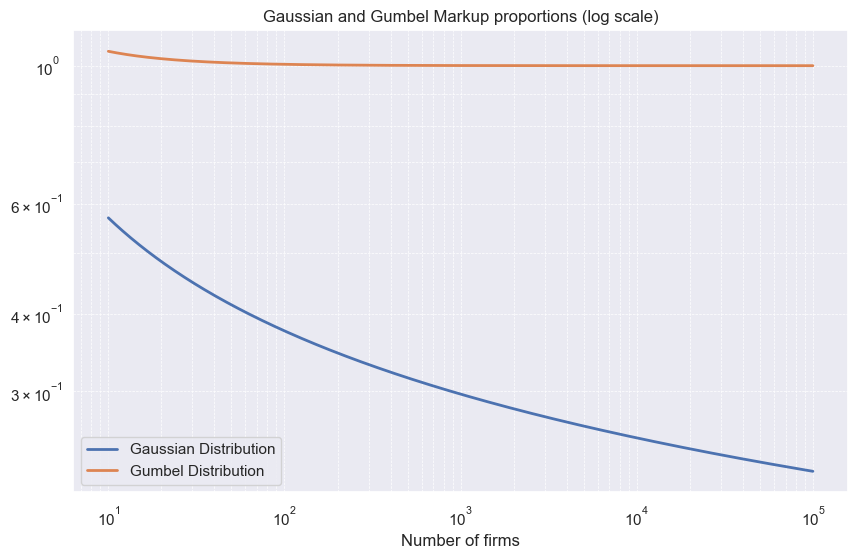

In [90]:
from scipy.stats import norm, gumbel_r

# Define the range for n (large n)
n_values = np.logspace(1, 5, 500)  # log-spaced values from 10 to 100000

# Normal distribution
# Inverse CDF (Quantile function) for Normal distribution
F_inv_normal = norm.ppf(1 - 1/n_values)
# PDF for Normal distribution at F_inv_normal
f_normal = norm.pdf(F_inv_normal)
# Expression for Normal distribution
expression_normal = 1 / (n_values * f_normal)

# Gumbel distribution
# Inverse CDF (Quantile function) for Gumbel distribution
F_inv_gumbel = gumbel_r.ppf(1 - 1/n_values)
# PDF for Gumbel distribution at F_inv_gumbel
f_gumbel = gumbel_r.pdf(F_inv_gumbel)
# Expression for Gumbel distribution
expression_gumbel = 1 / (n_values * f_gumbel)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_values, expression_normal, label="Gaussian Distribution", lw=2)
plt.plot(n_values, expression_gumbel, label="Gumbel Distribution", lw=2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of firms")
plt.title("Gaussian and Gumbel Markup proportions (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--", lw=0.5)
plt.show()